In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
path = 'input/'
train='train_sample.csv'
test='test.csv'

In [103]:
# This script recodes TalkingData click_time to a dhhmmss format (using only one digit
# of date number, since the date range in the training data is only 6 to 9) and uses
# the resulting series to identify the record sequence number for certain times
# (the times that I used to extract training and validation data in my pickle kernel)
#   https://www.kaggle.com/aharless/training-and-validation-data-pickle

import numpy as np
import pandas as pd
import gc

times = pd.read_csv('input/train.csv', usecols=['click_time'])
days = times.click_time.str[8:10].astype('uint8')
hours = times.click_time.str[11:13].astype('uint8')
minutes = times.click_time.str[14:16].astype('uint8')
seconds = times.click_time.str[17:19].astype('uint8')
times.shape, days.shape, hours.shape, minutes.shape, seconds.shape
del times
gc.collect()

ms = (minutes.astype('uint16')*100 + seconds).astype('uint16')
del minutes, seconds
gc.collect()

hms = (hours.astype('uint32')*10000 + ms).astype('uint32')
del hours, ms
gc.collect()

dhms = (days.astype('uint32')*1000000 + hms).astype('uint32')
del days, hms
gc.collect()

critical_times = [8160001,9040000,9060001,9090000,9110001,9130000,9150001]
print('\nRecords for critical times (dhhmmss):')
for dh in critical_times:
    print(dh, dhms[dhms>=dh].index[0])

print('\nOffsets:')    
print( dhms[dhms>=9060001].index[0] - dhms[dhms>=9040000].index[0] )
print( dhms[dhms>=9110001].index[0] - dhms[dhms>=9090000].index[0] )
print( dhms[dhms>=9150001].index[0] - dhms[dhms>=9130000].index[0] )



((184903890, 1), (184903890,), (184903890,), (184903890,), (184903890,))

95966

1898

0

0


Records for critical times (dhhmmss):
8160001 122071523
9040000 144708152
9060001 152413509
9090000 161974465
9110001 168265844
9130000 174976526
9150001 181878212

Offsets:
7705357
6291379
6901686


In [3]:
df_train =pd.read_csv(path+train,parse_dates=['click_time','attributed_time'])

In [65]:
df_test_full =pd.read_csv(path+test,parse_dates=['click_time'])

In [66]:
df_test_full['click_time']=pd.to_datetime(df_test_full['click_time']) #convert the click_time 
df_test_full['click_date'] = df_test_full['click_time'].dt.date
#df_train['click_timeonly']=df_train['click_time'].dt.time
df_test_full['click_hour']=df_test_full['click_time'].dt.hour


In [67]:
df_test_full.head()

,click_id,ip,app,device,os,channel,click_time,click_date,click_hour
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2017-11-10,4
1,1,119901,9,1,3,466,2017-11-10 04:00:00,2017-11-10,4
2,2,72287,21,1,19,128,2017-11-10 04:00:00,2017-11-10,4
3,3,78477,15,1,13,111,2017-11-10 04:00:00,2017-11-10,4
4,4,123080,12,1,13,328,2017-11-10 04:00:00,2017-11-10,4


In [68]:
df_test_full.click_date.unique()

array([datetime.date(2017, 11, 10)], dtype=object)

In [69]:
df_test_full.click_hour.unique()

array([ 4,  5,  6,  9, 10, 11, 13, 14, 15])

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null datetime64[ns]
attributed_time    227 non-null datetime64[ns]
is_attributed      100000 non-null int64
dtypes: datetime64[ns](2), int64(6)
memory usage: 6.1 MB


In [54]:
def parse_time(df_train):
    df_train['click_time']=pd.to_datetime(df_train['click_time']) #convert the click_time 
    df_train['click_date'] = df_train['click_time'].dt.date
    #df_train['click_timeonly']=df_train['click_time'].dt.time
    df_train['click_hour']=df_train['click_time'].dt.hour
    df_train['click_minute']=df_train['click_time'].dt.minute
    import datetime
    def update_date(dt):
        return dt.replace(minute=0, second=0) + datetime.timedelta(hours=1)
    df_train['click_date_hour']= df_train['click_time'].apply(update_date)
    return df_train
df_train=parse_time(df_train)

#df_train['click_second']=df_train['click_time'].dt.second

In [62]:
df_test=parse_time(df_test)

In [63]:
df_test.head()

,click_id,ip,app,device,os,channel,click_time,click_date,click_hour,click_minute
6229626,6229626,56643,21,1,19,232,2017-11-10 09:00:21,2017-11-10,9,0
2575476,2575474,41437,3,1,9,424,2017-11-10 04:45:46,2017-11-10,4,45
18678890,18678890,6650,2,1,35,477,2017-11-10 14:58:03,2017-11-10,14,58
1277066,1277066,31823,8,1,19,145,2017-11-10 04:22:28,2017-11-10,4,22
10197724,10197724,88547,1,1,3,134,2017-11-10 10:19:38,2017-11-10,10,19


In [30]:
print(df_train.describe())

                  ip           app         device             os  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean    91255.879670      12.04788      21.771250      22.818280   
std     69835.553661      14.94150     259.667767      55.943136   
min         9.000000       1.00000       0.000000       0.000000   
25%     40552.000000       3.00000       1.000000      13.000000   
50%     79827.000000      12.00000       1.000000      18.000000   
75%    118252.000000      15.00000       1.000000      19.000000   
max    364757.000000     551.00000    3867.000000     866.000000   

             channel  is_attributed  
count  100000.000000  100000.000000  
mean      268.832460       0.002270  
std       129.724248       0.047591  
min         3.000000       0.000000  
25%       145.000000       0.000000  
50%       258.000000       0.000000  
75%       379.000000       0.000000  
max       498.000000       1.000000  


In [7]:
df_date5=df_test[df_test.click_date==datetime.date(2017, 11, 6)]

In [23]:
df_train.click_date.unique()

array([datetime.date(2017, 11, 7), datetime.date(2017, 11, 9),
       datetime.date(2017, 11, 8), datetime.date(2017, 11, 6)],
      dtype=object)

In [71]:
df_test.click_hour.unique()

array([ 9,  4, 14, 10, 13,  5, 11,  6, 15])

In [98]:
df_test['is_attributed'] = pd.Series(data=1, index=df_test.index)

In [99]:
df_test.head()

,click_id,ip,app,device,os,channel,click_time,click_date,click_hour,click_minute,is_attributed,is_attributed
6229626,6229626,56643,21,1,19,232,2017-11-10 09:00:21,2017-11-10,9,0,1,1
2575476,2575474,41437,3,1,9,424,2017-11-10 04:45:46,2017-11-10,4,45,1,1
18678890,18678890,6650,2,1,35,477,2017-11-10 14:58:03,2017-11-10,14,58,1,1
1277066,1277066,31823,8,1,19,145,2017-11-10 04:22:28,2017-11-10,4,22,1,1
10197724,10197724,88547,1,1,3,134,2017-11-10 10:19:38,2017-11-10,10,19,1,1


In [24]:
df_date1=df_train[df_train.click_date==datetime.date(2017, 11, 6)]
df_date2=df_train[df_train.click_date==datetime.date(2017, 11, 7)]
df_date3=df_train[df_train.click_date==datetime.date(2017, 11, 8)]
df_date4=df_train[df_train.click_date==datetime.date(2017, 11, 9)]


In [19]:
df_date1.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_date,click_hour,click_minute,click_date_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07,9,30,2017-11-07 10:00:00
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07,13,40,2017-11-07 14:00:00
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07,18,5,2017-11-07 19:00:00
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07,4,58,2017-11-07 05:00:00
7,121505,9,1,25,442,2017-11-07 10:01:53,NaT,0,2017-11-07,10,1,2017-11-07 11:00:00


In [35]:
str(df_date1.click_date.reset_index(drop=True)[0])

'2017-11-06'

In [96]:
def plot_date_wise_hours(df_date1):
    with sns.axes_style('white'):
        g = sns.factorplot("click_hour", data=df_date1, aspect=4.0, kind='count',
                       hue='is_attributed')
        g.fig.suptitle(str(df_date1.click_date.reset_index(drop=True)[0]))
        g.set_xticklabels(step=1)
        

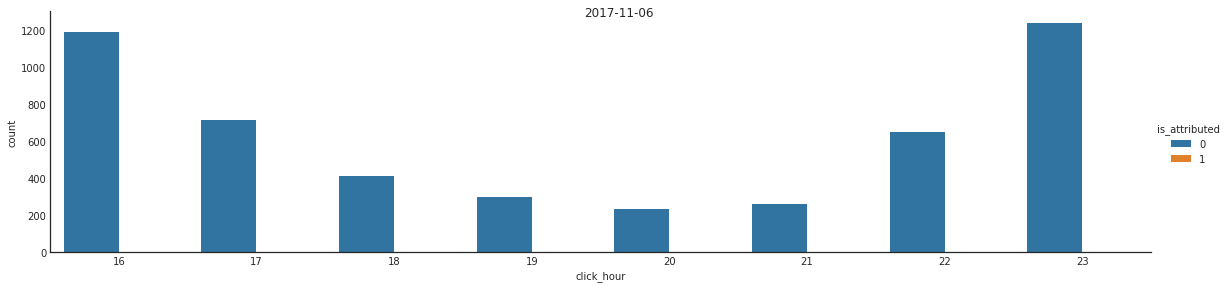

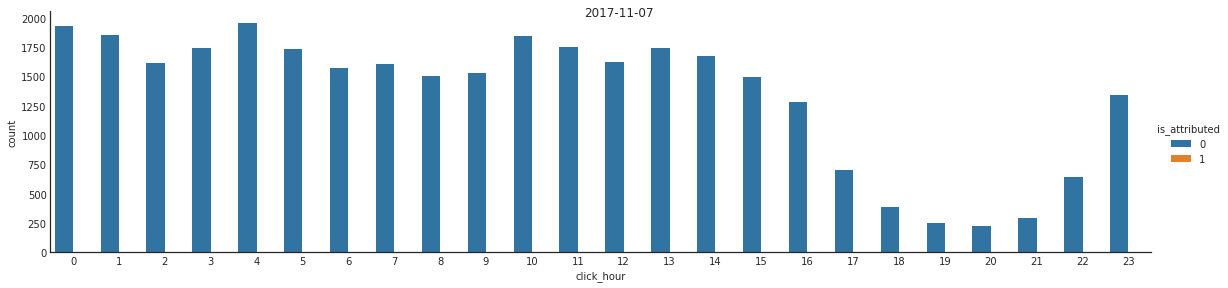

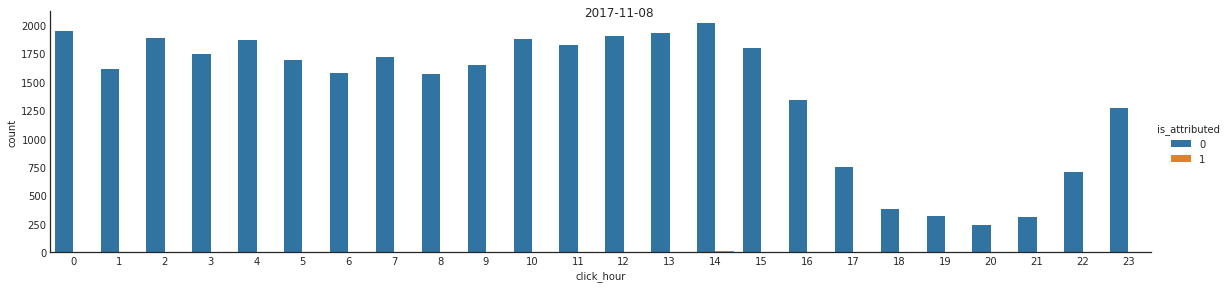

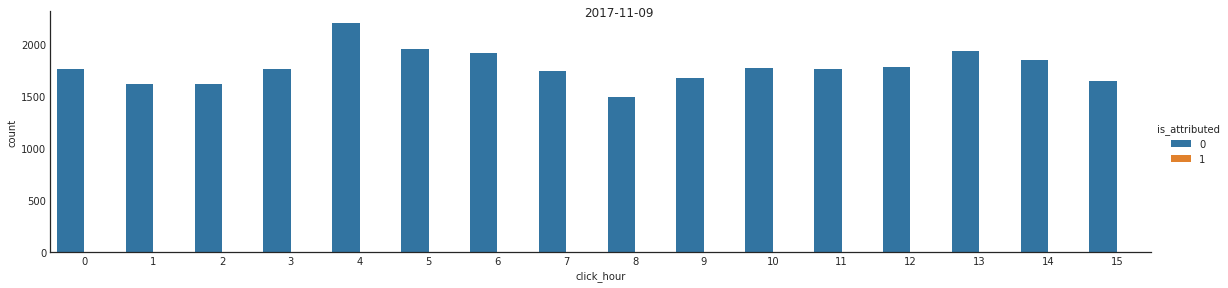

In [51]:
plot_date_wise_hours(df_date1)
plot_date_wise_hours(df_date2)
plot_date_wise_hours(df_date3)
plot_date_wise_hours(df_date4)

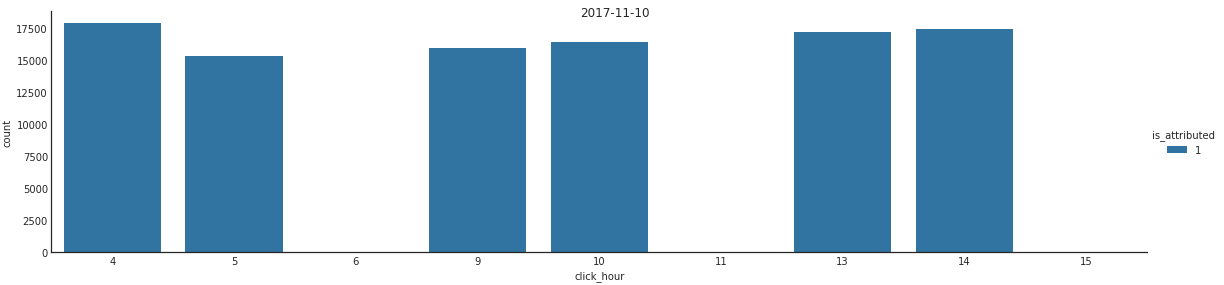

In [100]:
plot_date_wise_hours(df_test)

In [61]:
df_train['click_time']=pd.to_datetime(df_train['click_time']) #convert the click_time 

In [62]:
df_train.click_time.head()

0   2017-11-07 09:30:38
1   2017-11-07 13:40:27
2   2017-11-07 18:05:24
3   2017-11-07 04:58:08
4   2017-11-09 09:00:09
Name: click_time, dtype: datetime64[ns]

In [65]:
old_date=datetime.datetime(2017, 11, 7, 9, 30,38)

In [68]:
def update_date(dt):
    return dt.replace(minute=0, second=0) + datetime.timedelta(hours=1)
df_train['click_date_hour']= df_train['click_time'].apply(update_date)

In [69]:
df_train.click_date_hour.head()

0   2017-11-07 10:00:00
1   2017-11-07 14:00:00
2   2017-11-07 19:00:00
3   2017-11-07 05:00:00
4   2017-11-09 10:00:00
Name: click_date_hour, dtype: datetime64[ns]

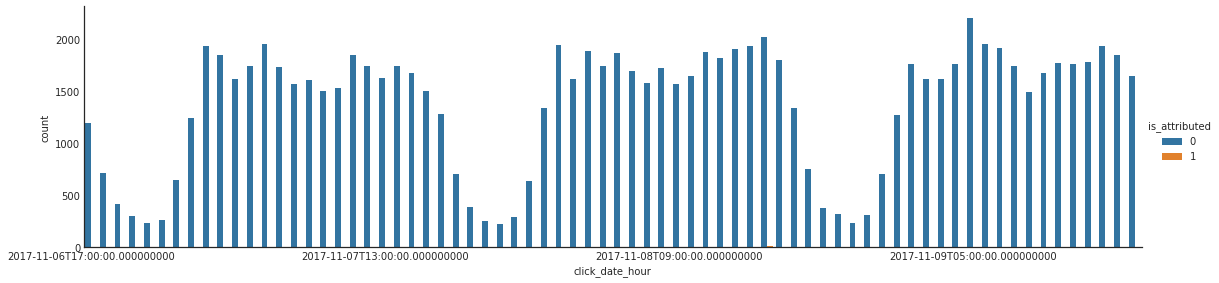

In [82]:
with sns.axes_style('white'):
    g = sns.factorplot("click_date_hour", data=df_train, aspect=4.0, kind='count',
                       hue='is_attributed')
    g.set_xticklabels(step=20)

TypeError: invalid type promotion

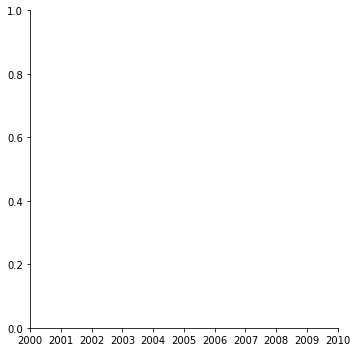

In [78]:
sns.lmplot(x='click_date_hour', y='is_attributed',
 data=df_train,lowess=True)

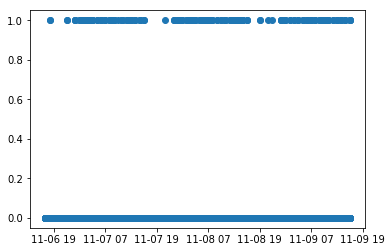

In [71]:
plt.plot_date(df_train.click_date_hour, df_train.is_attributed)

In [67]:
new_date

datetime.datetime(2017, 11, 7, 10, 0)

In [55]:
df_by_date_hour=df_train[['click_date','click_hour']].groupby(['click_date','click_hour'],sort=True)

In [60]:
df_by_date_hour.click_date.unique()

click_date  click_hour
2017-11-06  16            [2017-11-06]
            17            [2017-11-06]
            18            [2017-11-06]
            19            [2017-11-06]
            20            [2017-11-06]
            21            [2017-11-06]
            22            [2017-11-06]
            23            [2017-11-06]
2017-11-07  0             [2017-11-07]
            1             [2017-11-07]
            2             [2017-11-07]
            3             [2017-11-07]
            4             [2017-11-07]
            5             [2017-11-07]
            6             [2017-11-07]
            7             [2017-11-07]
            8             [2017-11-07]
            9             [2017-11-07]
            10            [2017-11-07]
            11            [2017-11-07]
            12            [2017-11-07]
            13            [2017-11-07]
            14            [2017-11-07]
            15            [2017-11-07]
            16            [2017-11-07]
  

In [ ]:
dates = matplotlib.dates.date2num(list_of_datetimes)
matplotlib.pyplot.plot_date(dates, values)


In [91]:
a=df_train[['click_date','click_hour']].sort_values(['click_date','click_hour'], ascending=[True, True])

In [92]:
a['click_date'==datetime.date(2017,11,6)]

KeyError: False

In [10]:
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_date,click_hour,click_minute
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07,9,30
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07,13,40
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07,18,5
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07,4,58
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09,9,0


In [11]:
#binning click hour into one of the 4 categories, we could categorieze them into most/least/none frequent hours in train,test
df_train['time_segment']=df_train.apply(lambda row: 0 if row.click_hour<6 else 
                                                      (1 if row.click_hour<9 else 
                                                       (2 if row.click_hour<18 else 
                                                        (3 if row.click_hour<22 else 0)
                                                       ) 
                                                      ), axis=1)
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_date,click_hour,click_minute,time_segment
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07,9,30,2
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07,13,40,2
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07,18,5,3
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07,4,58,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09,9,0,2


In [ ]:
#number of clicks for the same app before: app_click_count
#rearrange by app, click count? WHY??


In [ ]:
#calculate the number clicks for the same app in the same day before the current click

In [ ]:
#create the feature: app_channel_click_count ||||| (optional)before the click count?


In [ ]:
#calculate how many clicks have been made via the same ip + app + device + os + channel

In [ ]:
#iterate through the dataframe to count how many clicks had been made before the current click by same ip+app+device+os+channel

In [16]:
df_train=df_train.drop('click_time',axis=1)

In [17]:
df_train.head()

,ip,app,device,os,channel,attributed_time,is_attributed,click_date,click_hour,click_minute,time_segment
0,87540,12,1,13,497,NaT,0,2017-11-07,9,30,2
1,105560,25,1,17,259,NaT,0,2017-11-07,13,40,2
2,101424,12,1,19,212,NaT,0,2017-11-07,18,5,3
3,94584,13,1,13,477,NaT,0,2017-11-07,4,58,0
4,68413,12,1,1,178,NaT,0,2017-11-09,9,0,2


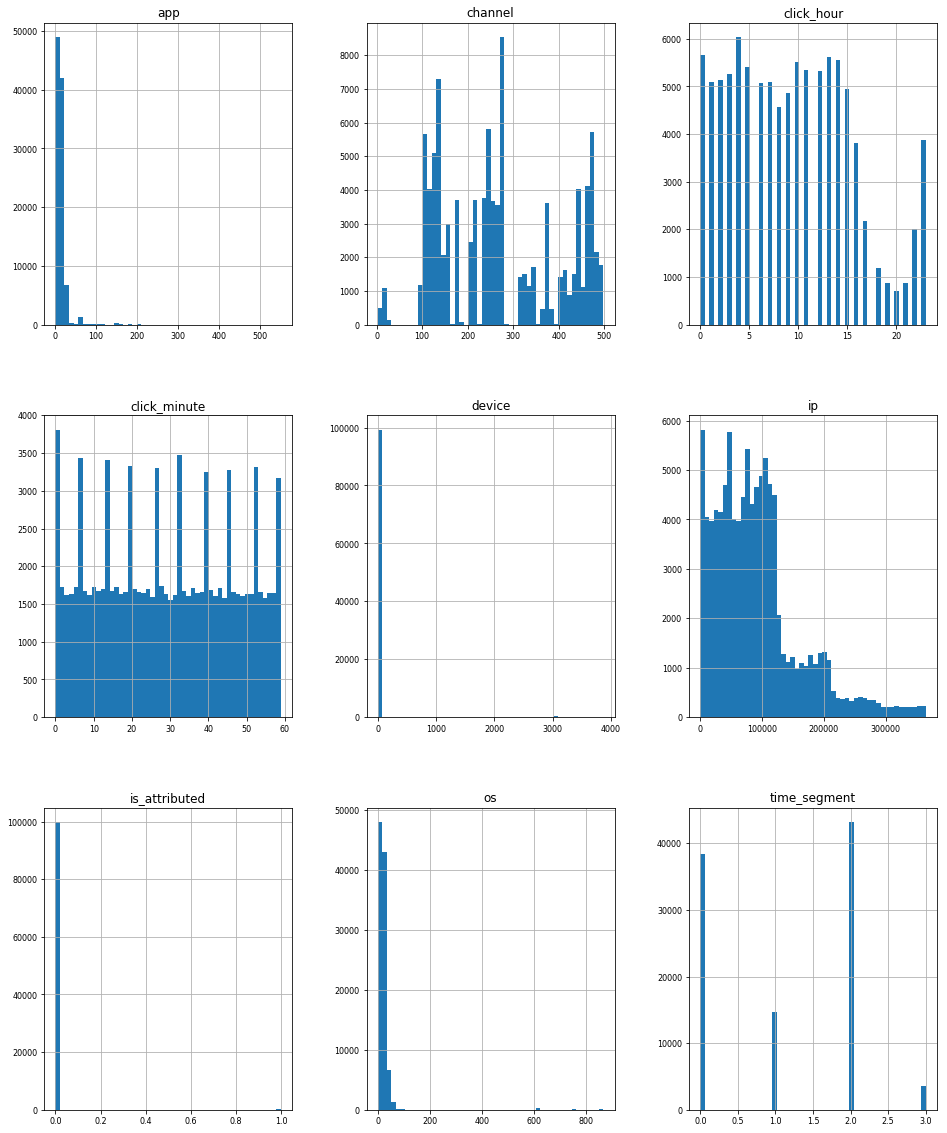

In [18]:
df_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

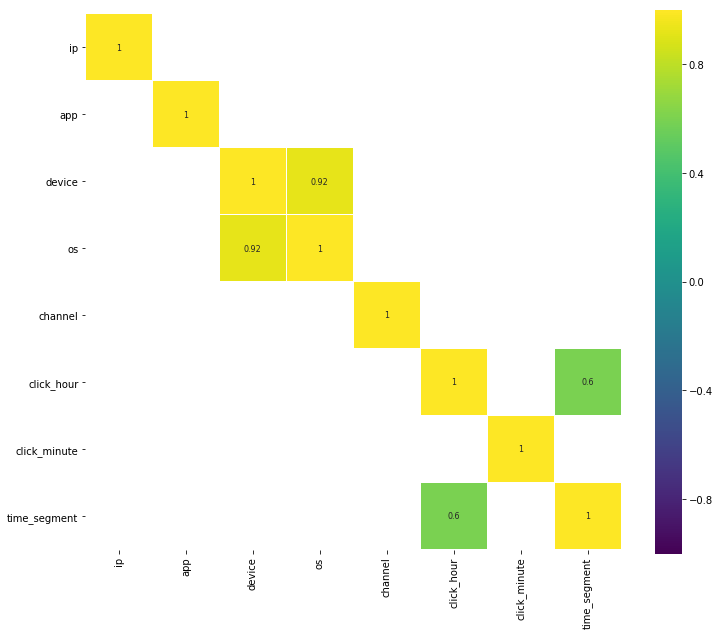

In [20]:
#correlation among featrue variables
corr = df_train.drop('is_attributed', axis=1).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

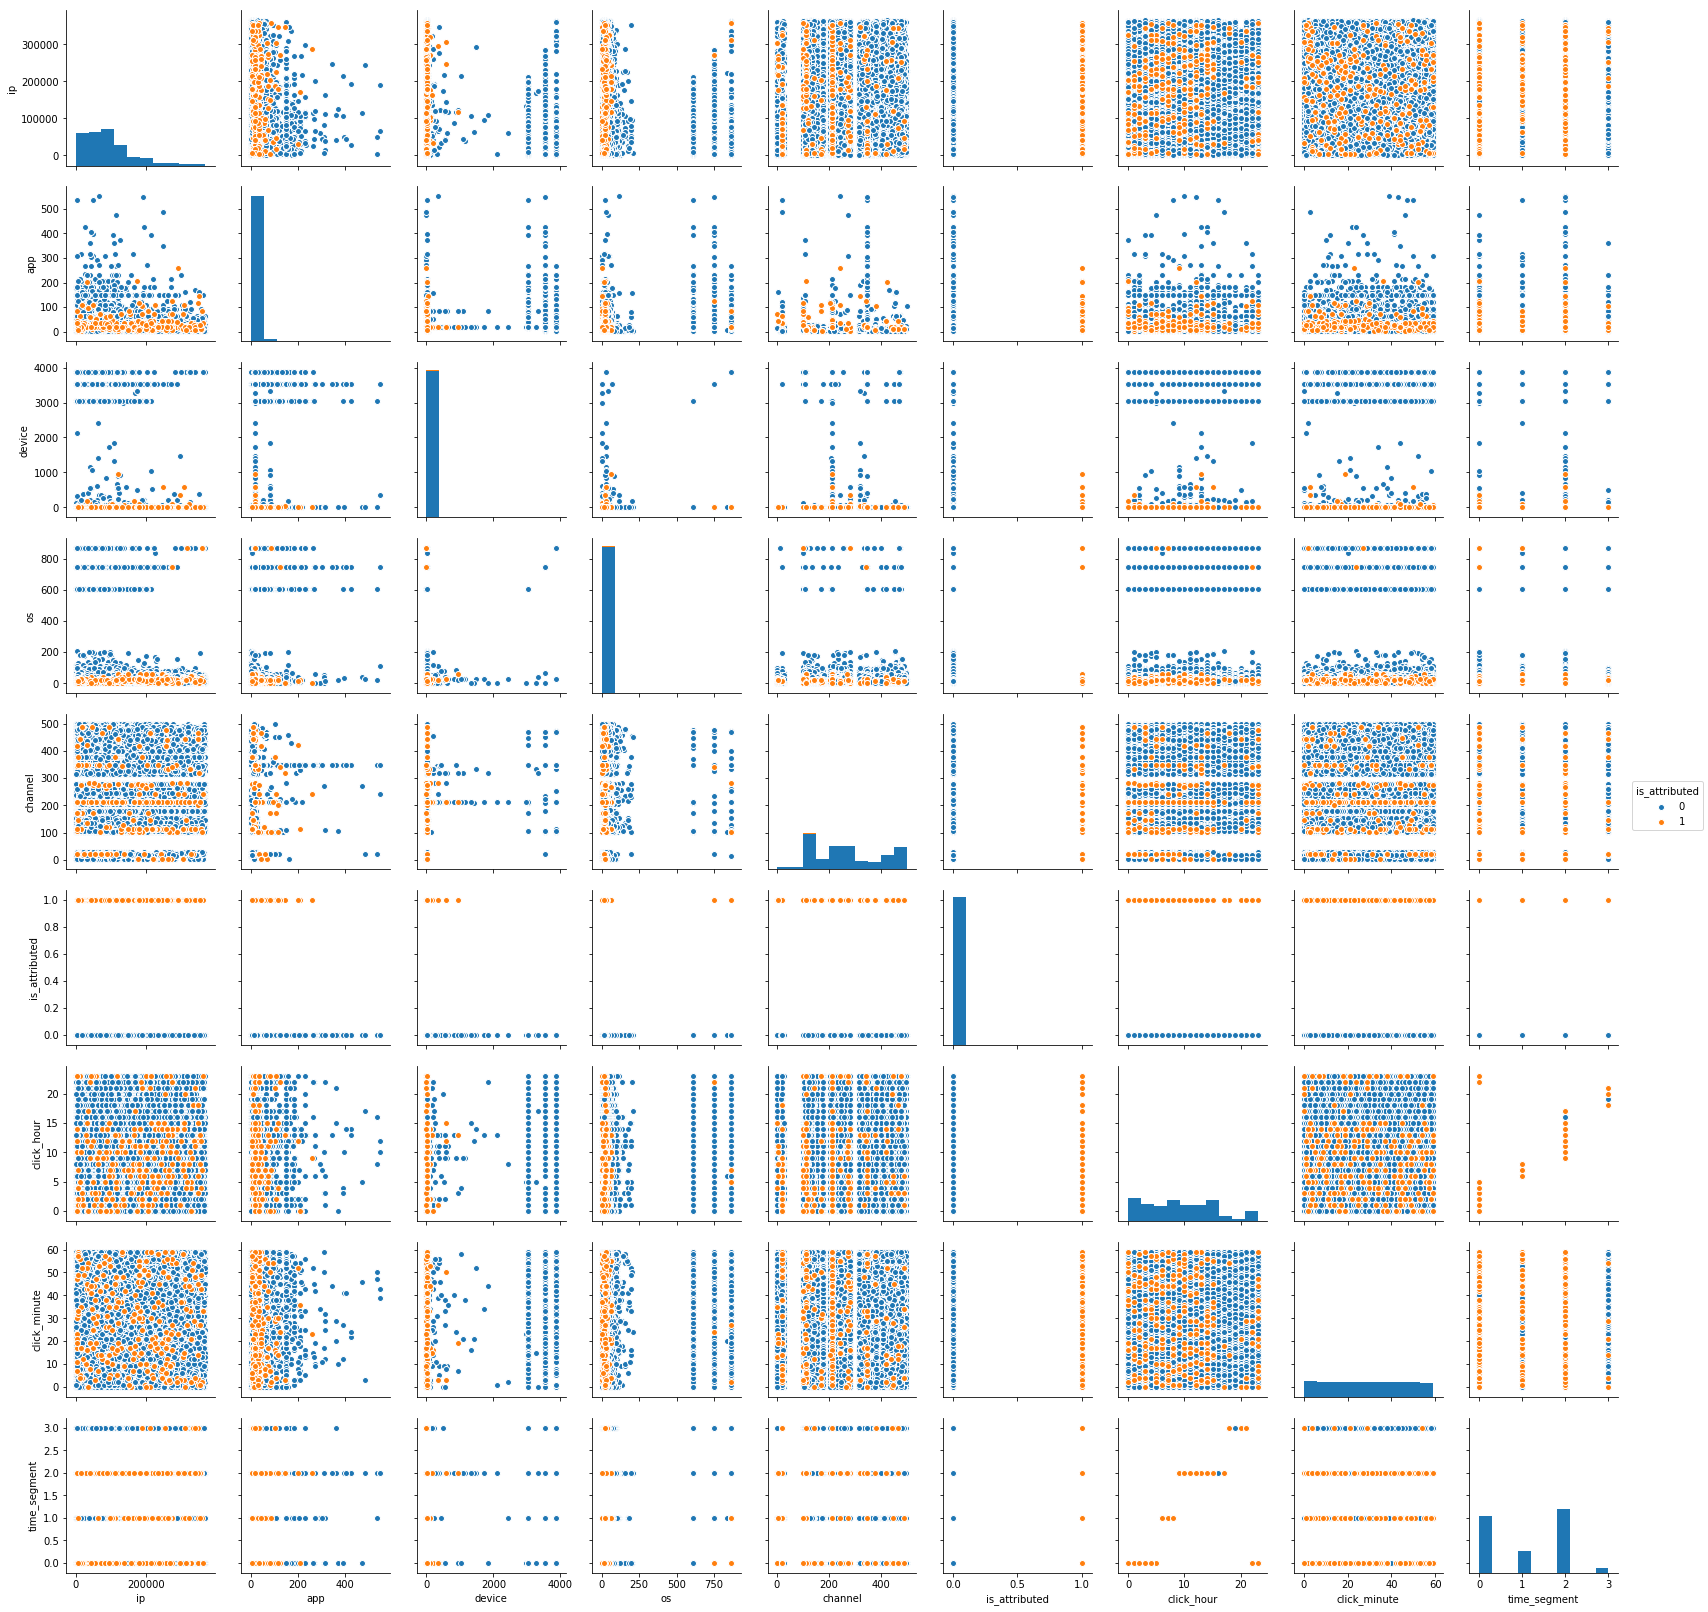

In [21]:
sns.pairplot(df_train, hue='is_attributed')

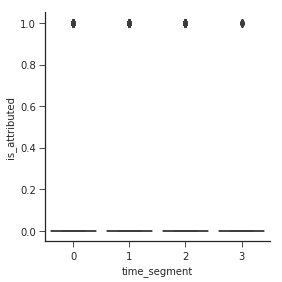

In [23]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("time_segment",  "is_attributed", data=df_train, kind="box")
    g.set_axis_labels("time_segment");

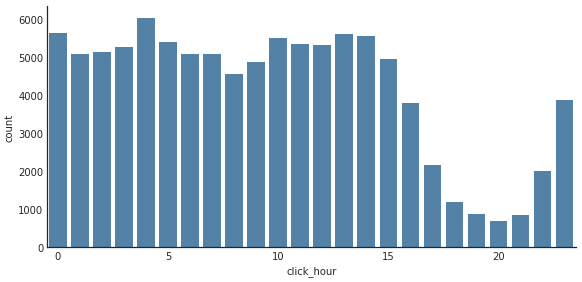

In [24]:
with sns.axes_style('white'):
    g = sns.factorplot("click_hour", data=df_train, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)